TP fais par : Leo Pellandini, Steven Jaquet et André Quintas Gervasio

# Exercice 2: Classification system with KNN - To Loan or Not To Loan

## Imports

Import some useful libraries

In [165]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

## a. Getting started

### Data loading

The original dataset comes from the Kaggle's [Loan Prediction](https://www.kaggle.com/ninzaami/loan-predication) problem. The provided dataset has already undergone some processing, such as removing some columns and invalid data. Pandas is used to read the CSV file.

In [166]:
data = pd.read_csv("loandata.csv")

Display the head of the data.

In [167]:
data.head()

,Gender,Married,Education,TotalIncome,LoanAmount,CreditHistory,LoanStatus
0,Male,Yes,Graduate,6091.0,128.0,1.0,N
1,Male,Yes,Graduate,3000.0,66.0,1.0,Y
2,Male,Yes,Not Graduate,4941.0,120.0,1.0,Y
3,Male,No,Graduate,6000.0,141.0,1.0,Y
4,Male,Yes,Graduate,9613.0,267.0,1.0,Y


Data's columns:
* **Gender:** Applicant gender (Male/ Female)
* **Married:** Is the Applicant married? (Y/N)
* **Education:** Applicant Education (Graduate/ Not Graduate)
* **TotalIncome:** Applicant total income (sum of `ApplicantIncome` and `CoapplicantIncome` columns in the original dataset)
* **LoanAmount:** Loan amount in thousands
* **CreditHistory:** Credit history meets guidelines
* **LoanStatus** (Target)**:** Loan approved (Y/N)

### Data preprocessing

Define a list of categorical columns to encode.

In [168]:
categorical_columns = ["Gender", "Married", "Education", "LoanStatus"]

Encode categorical columns using the [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) of scikit learn.

In [169]:
data[categorical_columns] = OrdinalEncoder().fit_transform(data[categorical_columns])

Split into `X` and `y`.

In [170]:
X = data.drop(columns="LoanStatus")
y = data.LoanStatus

Normalize data using the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of scikit learn.

In [171]:
X[X.columns] = StandardScaler().fit_transform(X[X.columns])

Convert `y` type to `int` 

In [172]:
y = y.astype(int)

Split dataset into train and test sets.

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## b. Dummy classifier

Build a dummy classifier that takes decisions randomly.

In [174]:
class DummyClassifier():
    
    def __init__(self):
        """
        Initialize the class.
        """
        
    
    def fit(self, X, y):
        """
        Fit the dummy classifier.
        
        Parameters
        ----------
        X : Numpy array or Pandas DataFrame of shape (n_samples, n_features)
            Training data.
        y : Numpy array or Pandas DataFrame of shape (n_samples,)
            Target values.
        """
        
    
    def predict(self, X):
        """
        Predict the class labels for the provided data.

        Parameters
        ----------
        X : Numpy array or Pandas DataFrame of shape (n_queries, n_features)
            Test samples.

        Returns
        -------
        y : Numpy array or Pandas DataFrame of shape (n_queries,)
            Class labels for each data sample.
        """
        
        n = len(X)  # nombre d'exemples
        return np.random.randint(0, 2, size=n)

Implement a function to evaluate the performance of a classification by computing the accuracy ($N_{correct}/N$).

In [175]:
def accuracy_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(y_true == y_pred)

Compute the performance of the dummy classifier using the provided test set.

In [176]:
# Création et entraînement d'un classifieur aléatoire
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

# prédiction sur l'ensemble de test
y_pred_dummy = dummy.predict(X_test)

# accurary 
acc = accuracy_score(y_test, y_pred_dummy)
print(f"Accuracy du classifieur aléatoire : {acc:.3f}")

Accuracy du classifieur aléatoire : 0.573


## c. K-Nearest Neighbors classifier

Build a K-Nearest Neighbors classifier using an Euclidian distance computation and a simple majority voting criterion.

In [177]:
class KNNClassifier():
    
    def __init__(self, n_neighbors=3):
        """
        Initialize the class.
        
        Parameters
        ----------
        n_neighbors : int, default=3
            Number of neighbors to use by default.
        """
        self.n_neighbors = n_neighbors

    
    def fit(self, X, y):
        """
        Fit the k-nearest neighbors classifier.
        
        Parameters
        ----------
        X : Numpy array or Pandas DataFrame of shape (n_samples, n_features)
            Training data.
        y : Numpy array or Pandas DataFrame of shape (n_samples,)
            Target values.
        """
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y) 
    
    @staticmethod
    def _euclidian_distance(a, b):
        """
        Utility function to compute the euclidian distance.
        
        Parameters
        ----------
        a : Numpy array or Pandas DataFrame
            First operand.
        b : Numpy array or Pandas DataFrame
            Second operand.
        """
        # Version claire avec (a - b) ** 2
        return np.sqrt(((a - b) ** 2).sum(axis=1))  
    
    def _predict_one(self, x):
        # distances entre x et tous les points du train 
        dists = np.linalg.norm(self.X_train - x, axis=1)

        # indices des k plus proches voisins
        k = self.n_neighbors
        idx = np.argpartition(dists, k)[:k]

        # vote tout bête : moyenne des labels puis arrondi (0/1)
        pred = np.rint(self.y_train[idx].mean()).astype(int)
        return int(pred)

    def predict(self, X):
        """
        Predict the class labels for the provided data.

        Parameters
        ----------
        X : Numpy array or Pandas DataFrame of shape (n_queries, n_features)
            Test samples.

        Returns
        -------
        y : Numpy array or Pandas DataFrame of shape (n_queries,)
            Class labels for each data sample.
        """
        X = np.asarray(X)
        y = np.empty(len(X), dtype=int)
        for i, row in enumerate(X):
            y[i] = self._predict_one(row)
        return y

Compute the performance of the system as a function of $k = 1...7$.

In [178]:
# test du KNN pour plusieurs valeurs de k
for k in range(1, 8):
    model = KNNClassifier(k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"k = {k}  →  accuracy : {acc}")

k = 1  →  accuracy : 0.6979166666666666
k = 2  →  accuracy : 0.6354166666666666
k = 3  →  accuracy : 0.7916666666666666
k = 4  →  accuracy : 0.7395833333333334
k = 5  →  accuracy : 0.8125
k = 6  →  accuracy : 0.78125
k = 7  →  accuracy : 0.8020833333333334


La précision augmente quand on passe d’un seul voisin à plusieurs, atteint son maximum à k = 5 (≈81 %), puis redescend légèrement ; cela montre qu’un petit nombre de voisins réduit le bruit, mais qu’un k trop grand n'est pas forcement benefique

Run the KNN algorithm using only the features `TotalIncome` and `CreditHistory`.

In [179]:
X_limited_train = X_train[["TotalIncome", "CreditHistory"]]
X_limited_test = X_test[["TotalIncome", "CreditHistory"]]

for k in range(1, 8):
    model = KNNClassifier(k)
    model.fit(X_limited_train, y_train)
    preds = model.predict(X_limited_test)
    acc = accuracy_score(y_test, preds)
    print(f"k = {k}  →  accuracy : {acc:.3f}")


k = 1  →  accuracy : 0.760
k = 2  →  accuracy : 0.688
k = 3  →  accuracy : 0.781
k = 4  →  accuracy : 0.698
k = 5  →  accuracy : 0.823
k = 6  →  accuracy : 0.771
k = 7  →  accuracy : 0.812


Re-run the KNN algorithm using the features `TotalIncome`, `CreditHistory` and `Married`.

In [180]:
X_train_limited = X_train[["TotalIncome", "CreditHistory", "Married"]]
X_test_limited = X_test[["TotalIncome", "CreditHistory", "Married"]]

for k in range(1, 8):
    model = KNNClassifier(k)
    model.fit(X_train_limited, y_train)
    preds = model.predict(X_test_limited)
    acc = accuracy_score(y_test, preds)
    print(f"For k={k} : P = {acc}")

For k=1 : P = 0.7916666666666666
For k=2 : P = 0.6875
For k=3 : P = 0.8645833333333334
For k=4 : P = 0.7604166666666666
For k=5 : P = 0.8020833333333334
For k=6 : P = 0.75
For k=7 : P = 0.7916666666666666


Re-run the KNN algorithm using all features.

In [181]:
X = data[["TotalIncome", "CreditHistory"]]

# Normalisation
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# evaluation pour k = 1..7
for k in range(1, 8):
    model = KNNClassifier(k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"For k={k} : P = {acc}")

For k=1 : P = 0.7604166666666666
For k=2 : P = 0.6875
For k=3 : P = 0.78125
For k=4 : P = 0.6979166666666666
For k=5 : P = 0.8229166666666666
For k=6 : P = 0.7708333333333334
For k=7 : P = 0.8125


e) Do it again by using all the features available. Compare the performance obtained when
using different number of features. What do you notice? What can you tell about the
relationship between the performance, the number of samples and the number of features
when using this algorithm?

on constate que rajouter une troisième variable améliore légèrement l’accuracy (jusqu’à ~86 % avec k=3), alors que l’utilisation de toutes les features n’apporte pas de gain plus élevé que 86%

Cela montre que KNN ne profite pas de l’ajout de nouvelles dimensions : si celles-ci n’apportent pas d’information utile ou si le nombre d’échantillons reste limité, les distances deviennent moins discriminantes.

Le graphe est ci-dessous :

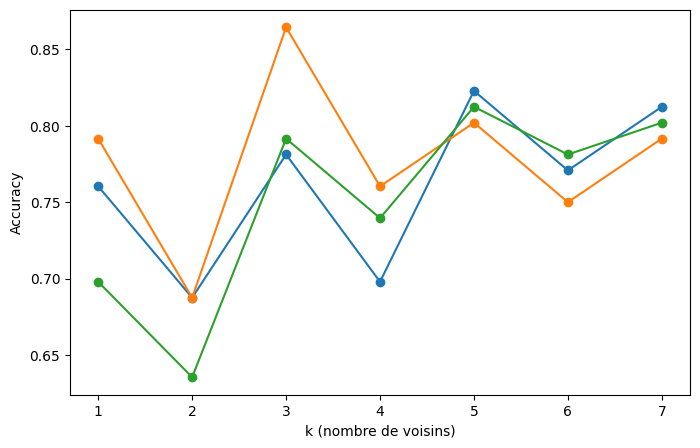

In [182]:
import matplotlib.pyplot as plt

X = data.drop(columns=["LoanStatus"]).copy()
y = data["LoanStatus"].to_numpy()

# si colonnes texte on les encode
for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category").cat.codes

# normalisation
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns
)

# on teste : 2 features, 3 features, toutes
feature_sets = [
    ["TotalIncome", "CreditHistory"],
    ["TotalIncome", "CreditHistory", "Married"],
    list(X_scaled.columns)  # toutes
]

scores = {}

for features in feature_sets:
    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled[features], y, stratify=y, test_size=0.2, random_state=42
    )

    acc_list = []
    for k in range(1, 8):
        model = KNNClassifier(k)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        acc_list.append(acc)
    scores[", ".join(features) if len(features)<=3 else "All features"] = acc_list

# --- Affichage ---
plt.figure(figsize=(8,5))
for label, acc_list in scores.items():
    plt.plot(range(1,8), acc_list, marker='o', label=label)
plt.xlabel("k (nombre de voisins)")
plt.ylabel("Accuracy")
plt.show()


TP fais par : Leo Pellandini, Steven Jaquet et André Quintas Gervasio

f) How is your system taking decisions when you have an equal number of votes for both
classes with values of k = 2, 4, 6 ?

On voit donc que lorsqu’il y a égalité entre les classes, l’algorithme décide par défaut de renvoyer la classe 0.

Quand il y a égalité, la moyenne des étiquettes vaut 0.5 et la fonction round/np.rint arrondit 0.5 à 0 ; le modèle prédit donc toujours la classe 0 en cas d’égalité.

Comme on voit si-dessous avec un dataset fais à la main:

In [183]:
X_train = np.array([[1,0],[-1,0],[0,1],[0,-1],[2,0],[-2,0],[0,2],[0,-2]], float)
y_train = np.array([0,0,1,1,0,0,1,1])
X_test = np.array([[0., 0.]])

def votes(x, k):
    d = np.linalg.norm(X_train - x, axis=1)
    k = min(k, len(X_train)-1)
    idx = np.argsort(d)[:k]
    labs = y_train[idx]
    print(f"k={k}: 0={sum(labs==0)}, 1={sum(labs==1)}")
    return k

for k in [2,4,6]:
    k_eff = votes(X_test[0], k)
    m = KNNClassifier(k_eff)
    m.fit(X_train, y_train)
    print(" prédiction:", m.predict(X_test)[0])

k=2: 0=2, 1=0
 prédiction: 0
k=4: 0=2, 1=2
 prédiction: 0
k=6: 0=4, 1=2
 prédiction: 0
